# Exercise 01: The First Step with PyTorch

In this exercise, you will learn how to explore data with the commonly used library – PyTorch.
You will conduct several simple analyses and visualizations on the CIFAR-10 dataset, which is
a popular dataset for multi-class classification.

In [8]:
from imbalance_data.cifar10Imbanlance import Cifar10Imbanlance
import warnings
warnings.filterwarnings("ignore")
import torch
import matplotlib.pyplot as plt
import numpy as np
import  torchvision.transforms as transforms

## Imbanlanced CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The CIFAR10-LT is a long-tailed version of the CIFAR10 dataset, where some classes have a
disproportionately higher number of instances than others. There we will generate an long-tailed dataset from CIFAR-10 by ``Cifar10Imbanlance`` class.

Generate an imbanlanced dataset 

In [9]:
imbanlance_rate = 0.1
# the dataset directory
root = "/shareddata/"
trainset = Cifar10Imbanlance(imbanlance_rate, transform=transforms.ToTensor(), train=True, file_path=root)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)


Files already downloaded and verified


Labels of Cifar10 are below.

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

There we define a function called ``plot_cifar10``, which can plot ten pictures from a given batch.

In [11]:

def plot_cifar10(images,labels):
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        image = images[i].numpy()
        label = labels[i].item()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(class_names[label])
        plt.axis('off')

    plt.show()

Plot CIFAR-10 data set images and corresponding labels.

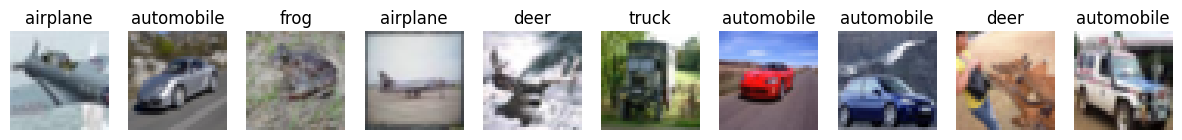

In [12]:
# Creat an iterator object `dataiter` from the `train_dataloader`
# then use the `next()` function to get the next batch of images and labels from the iterator. 
# This allows us to access the data in batches for training or evaluation purposes.
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
plot_cifar10(images,labels)

## Exercise

---

### Task 1: class prior estimation
Please denfine a function named ``count_class_instances`` that takes a dataloader as input and obtains the **sample size of each class** in this
dataset. It returns a tensor containing the count of each class.

In [13]:
def count_class_instances(train_dataloader):
    # write your code there
     # Initialize a tensor of zeros with a size equal to the number of classes
    class_counts = torch.zeros(10, dtype=torch.int64)
    
    # Iterate through each batch in the dataloader
    for _, labels in train_dataloader:
        # Count unique instances and their occurrences
        unique_labels, counts = torch.unique(labels, return_counts=True)
        
        # Add the counts to the class_counts tensor
        class_counts[unique_labels] += counts
    # The output of the function should be a tensor that contains the sample size of each class.
    # class_counts is an tensors with shape torch.Size([10])
    return class_counts

Then we calculate and display the number of samples or instances for each class using the ``count_class_instances`` function. 

In [14]:
class_counts = count_class_instances(train_dataloader)

for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {int(count)} samples")

airplane: 5000 samples
automobile: 3871 samples
bird: 2997 samples
cat: 2320 samples
deer: 1796 samples
dog: 1391 samples
frog: 1077 samples
horse: 834 samples
ship: 645 samples
truck: 500 samples


---
### Task 2: dataset statistics calculation

Please denfine a function named ``compute_channel_mean_std``, which iscalculates the channel-wise mean (mu, $\mu$) and standard deviation (std, $\sigma$). It takes a dataloader as input.



In [15]:
def compute_channel_mean_std(train_dataloader):
    # write your code there
     # Initialization of variables to hold sum and square sum of channels
    channel_sum = torch.zeros(3)
    channel_square_sum = torch.zeros(3)
    total_images = 0

    # Looping through the dataloader to get all the images
    for images, _ in train_dataloader:
        total_images += images.size(0)  # Update the count of images
        channel_sum += images.sum(dim=[0, 2, 3])  # Sum of channels for current batch
        channel_square_sum += (images ** 2).sum(dim=[0, 2, 3])  # Sum of squares of channels for current batch

    # Calculating mean and standard deviation
    channel_means = channel_sum / (total_images * images.size(2) * images.size(3))
    channel_stddevs = (channel_square_sum / (total_images * images.size(2) * images.size(3)) - channel_means ** 2) ** 0.5
    # The outputs of the function should be two tensors: mu and std, which contain three values corresponding to the three channels.
    # channel_means, channel_stddevs are tensors with shape torch.Size([3])
    return channel_means, channel_stddevs

There we print means and deviations for each channels.

In [16]:
channel_means, channel_stddevs = compute_channel_mean_std(train_dataloader)
print("Channel means:", channel_means)
print("Channel standard deviations:", channel_stddevs)

Channel means: tensor([0.4946, 0.4908, 0.4643])
Channel standard deviations: tensor([0.2486, 0.2456, 0.2673])


Then we plot normalized images with corresponding labels.

Files already downloaded and verified


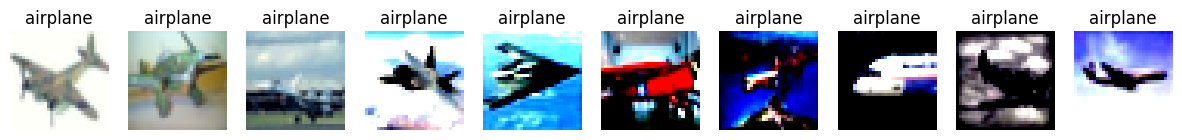

In [23]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = channel_means, std = channel_stddevs)])
trainset_normalize = Cifar10Imbanlance(imbanlance_rate, transform=transform, train=True, file_path=root)
train_normalize_dataloader = torch.utils.data.DataLoader(trainset_normalize, batch_size=128, shuffle=False)
dataiter = iter(train_normalize_dataloader)
images, labels = next(dataiter)

def unnormalize_and_clip(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

images = unnormalize_and_clip(images, channel_means, channel_stddevs)

plot_cifar10(images,labels)
